<a href="https://colab.research.google.com/github/naldo14/tesis-/blob/main/BBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## importo las librerias
import h5py
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow import keras
tfd = tfp.distributions
tfpl = tfp.layers

In [3]:
## hago el mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Proceso de carga de los datos

## data sobre el eje y

In [4]:
#creo el h5py de las features
path_features="/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/features_y"
hdf5_file_path = path_features
with h5py.File(hdf5_file_path, 'r') as hf:
    y_features = hf['features_y'][:]


In [5]:

path_features="/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/y_targets"
hdf5_file_path = path_features
with h5py.File(hdf5_file_path, 'r') as hf:
    y_targets = hf['y_targets'][:]

In [6]:
y_targets.shape

(55,)

### data sobre el eje *x*

In [7]:
#creo el h5py de las features
path_features="/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/features_x"
hdf5_file_path = path_features
with h5py.File(hdf5_file_path, 'r') as hf:
   x_features = hf['features_x'][:]


In [8]:
path_features="/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/x_targets"
hdf5_file_path = path_features
with h5py.File(hdf5_file_path, 'r') as hf:
    x_targets = hf['x_targets'][:]

In [ ]:
## data sets but using y-axis measures
from sklearn.model_selection import train_test_split
# Assuming x is your dataset with shape (70, 14) and y is your labels
x_train, x_test, y_train, y_test = train_test_split(y_features, y_targets, test_size=0.3, random_state=42)

print("corrida usando el eje y")

In [9]:
## data sets but using x-axis measures
from sklearn.model_selection import train_test_split
# Assuming x is your dataset with shape (70, 14) and y is your labels
x_train, x_test, y_train, y_test = train_test_split(x_features, x_targets, test_size=0.3, random_state=42)
print("corrida usando el eje x")

corrida usando el eje x


In [ ]:
del x_train, x_test, y_train, y_test

### Creacion de la BNN

In [10]:
## def prior weight distribution N(1,0) and not trainable
# Define the prior weight distribution N(0, 1)
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

In [11]:
# Define the posterior weight distribution Multivariate Gaussian distribution
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [38]:
# Define the BNN model
model = tf.keras.Sequential([
    tfpl.DenseVariational(
        input_shape=(14,),
        units=30,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        kl_weight=1/x_train.shape[0],  # KL Weight
        # kl_use_exact=True
    ),

       tfpl.DenseVariational(
        units=25,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),

    tfpl.DenseVariational(
        units=20,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),

    tfpl.DenseVariational(
        units=15,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),


      tfpl.DenseVariational(
        units=12,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),
    tfpl.DenseVariational(
        units=8,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),
    tfpl.DenseVariational(
        units=5,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),
    tfpl.DenseVariational(
        units=1,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='sigmoid',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),
])

In [37]:
del model

In [19]:

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_16 (Dens  (None, 30)                101925    
 eVariational)                                                   
                                                                 
 dense_variational_17 (Dens  (None, 25)                301475    
 eVariational)                                                   
                                                                 
 dense_variational_18 (Dens  (None, 20)                135980    
 eVariational)                                                   
                                                                 
 dense_variational_19 (Dens  (None, 15)                50085     
 eVariational)                                                   
                                                                 
 dense_variational_20 (Dens  (None, 12)               

In [39]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])

# Train the model
history = model.fit(x_train, y_train, epochs=1000, verbose=2)

# Evaluate the model on the test data
test_loss, test_accuracy, false_negatives, false_positives = model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"False Negatives: {false_negatives:.0f}")
print(f"False Positives: {false_positives:.0f}")

# Make predictions on test data
y_pred = model.predict(x_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(confusion)


Epoch 1/1000
2/2 - 9s - loss: 9.9128 - accuracy: 0.4583 - false_negatives_2: 21.0000 - false_positives_2: 5.0000 - 9s/epoch - 5s/step
Epoch 2/1000
2/2 - 0s - loss: 15.5555 - accuracy: 0.4583 - false_negatives_2: 13.0000 - false_positives_2: 13.0000 - 62ms/epoch - 31ms/step
Epoch 3/1000
2/2 - 0s - loss: 33.8830 - accuracy: 0.2917 - false_negatives_2: 32.0000 - false_positives_2: 2.0000 - 60ms/epoch - 30ms/step
Epoch 4/1000
2/2 - 0s - loss: 36.9451 - accuracy: 0.3542 - false_negatives_2: 28.0000 - false_positives_2: 3.0000 - 57ms/epoch - 28ms/step
Epoch 5/1000
2/2 - 0s - loss: 8.7518 - accuracy: 0.7083 - false_negatives_2: 0.0000e+00 - false_positives_2: 14.0000 - 67ms/epoch - 33ms/step
Epoch 6/1000
2/2 - 0s - loss: 12.0567 - accuracy: 0.6667 - false_negatives_2: 1.0000 - false_positives_2: 15.0000 - 58ms/epoch - 29ms/step
Epoch 7/1000
2/2 - 0s - loss: 38.4627 - accuracy: 0.4583 - false_negatives_2: 21.0000 - false_positives_2: 5.0000 - 57ms/epoch - 28ms/step
Epoch 8/1000
2/2 - 0s - loss

1/1 [==============================] - 0s 38ms/step


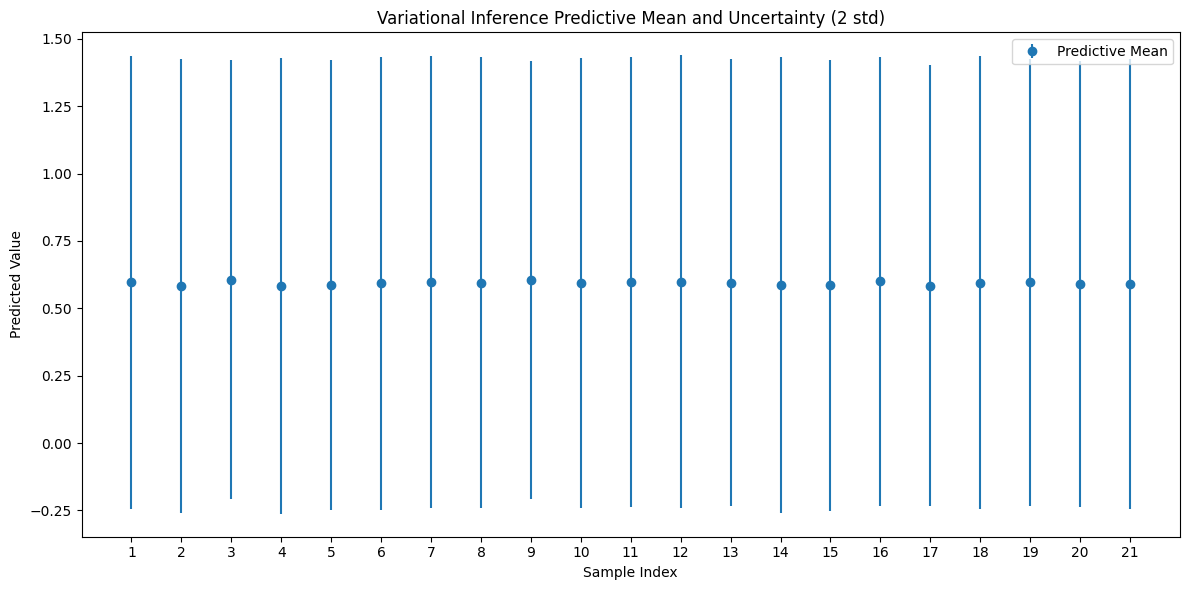

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Number of samples for uncertainty estimation
n_samples = 100
predictions = []

# Generate multiple samples from the posterior distribution
for _ in range(n_samples):
    predictions.append(model.predict(x_test))

# Convert predictions to a NumPy array
predictions = np.array(predictions)

# Calculate the predictive mean and standard deviation
mean_prediction = np.mean(predictions, axis=0).flatten()
std_prediction = np.std(predictions, axis=0).flatten()

# Create x-axis values
x_values = np.arange(1, len(mean_prediction) + 1)

# Plot uncertainty using error bars
plt.figure(figsize=(12, 6))
plt.errorbar(x_values, mean_prediction, yerr=2 * std_prediction, fmt='o', label='Predictive Mean')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.xticks(x_values)  # Set the x-axis ticks to the specific numbers
plt.title('Variational Inference Predictive Mean and Uncertainty (2 std)')
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
len(x_test)


21

In [35]:
y_pred_1= model.predict(x_test)


1/1 [==============================] - 0s 25ms/step


In [36]:
y_pred_1

array([[0.54219264],
       [0.7883052 ],
       [0.997053  ],
       [0.54219264],
       [0.54219264],
       [0.54219264],
       [0.54219264],
       [0.54219264],
       [0.99715084],
       [0.54219264],
       [0.54219264],
       [0.54219264],
       [0.54219264],
       [0.54219264],
       [0.67361194],
       [0.54219264],
       [0.54219264],
       [0.54219264],
       [0.54219264],
       [0.54219264],
       [0.54219264]], dtype=float32)